In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv();

In [3]:
import base64
import json
import logging
import os
import re
import smtplib
import sys
import time
import threading
import traceback
from copy import deepcopy
from functools import partial, wraps
from itertools import chain
from importlib import reload
from pathlib import Path
from uuid import uuid4
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart

import bhutils
import blpapi
import ipyvuetify as v
import ipywidgets as w
import numpy as np
import pandas as pd
import clarion
import QuantLib as ql
import dataframe_image as dfi
import schedule
import win32com.client as win32
from bqplot import ColorScale, LinearScale, OrdinalColorScale, OrdinalScale
from ipydatagrid import BarRenderer, DataGrid, Expr, TextRenderer, VegaExpr
from IPython.display import display, clear_output
from pandas.tseries.offsets import BDay
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from blp.blp import BlpParser

from api.watchdog import specs
from api.watchdog.specs import get_trades, get_targets
from api.watchdog.pricer import Pricer
from api.history_plotter_v2 import ExpressionHandler
from api.email import smtp_server, to_email_test, to_email_all, df_to_html, from_email, to_email_ext
from gioutils.clarion_ext import Runner
from gioutils.tools_clarion import get_clarion_positions
from gioutils.gui.pandas import millifyp as millify
from gioutils import ezutils as ez
from gioutils.blpw import BlpParser, BlpQuery
from gioutils.clarion_ext import super_clarion
from gioutils.tools import parse_swap_periods
from gioutils.ezutils import (
    bh,
    bhs,
    get_id,
    get_price_info,
)

from gioutils.utils import (
    get_bday,
    get_next_n,
    parse_offset,
    today,
    get_generic_future, 
    get_bbg_fut_chain_ticker,
    get_specific_future,
    get_root,
    encode_plotly_fig_as_image_tag,
)
from gioutils.tools_clarion import get_history_plotter_book

pd.options.plotting.backend = "plotly"
pd.options.display.float_format = partial(millify, pct=None, decimal=2)

In [4]:
from api.jobs.risk import daily_var_email
from api.jobs.risk_intraday import var_reduction_email
from api.jobs.macd_watcher import macd_signals_email, make_plotly_fig
from api.jobs.positions import history_plotter_email

In [58]:
clarion.server_login()
bq = BlpQuery(timeout=50000, parser=BlpParser(raise_security_errors=False)).start()
clear_output()
# ba = BHSysApi(password="A&3jg5Aj")

In [6]:
super_clarion(clarion)
runner = Runner(clarion)

### Functions

### Expression
It's a dictionary where the key corresponds to the name of the time series, while the value can be one of:
- **dict, tuple, list**: in this case it behaves like the historical pricer and uses the underlying **irbt_remote**
- **str**: in this case uses the old engine as in **translation** and the instrument is defined as **[s usd.sofr 11mx2y]**. Currently only swaps as supported using this method

### Example
Create an instance of **ExpressionHandler** and *call get_data(expressions, \*\*kwargs)*
The instance has now two dataframe attributes:
- **expressions_data**: contains all the calculated expressions
- **components_data**: contains all the individual components needed to calculate the expressions 

In [44]:
mtg_dts = bq.bdp(
    securities=[
        "USSOFED2 Curncy",
        "USSOFED3 Curncy",
        "USSOFED4 Curncy",
        "USSOFED5 Curncy",
        "USSOFED6 Curncy",
    ],
    fields={
        "sw_eff_dt": 'start',
        "maturity": 'mty',
        'px_last': 'last_price'
    }
)

In [45]:
mtg_dts = pd.concat([mtg_dts, pd.DataFrame(mtg_dts.apply(lambda row: parse_swap_periods(row['start'], row['mty'], use_weeks=True), axis=1).str.split('x').to_list(), columns=['start_cont', 'tenor'])], axis=1)
mtg_dts = mtg_dts.assign(
    label=[f"{date:%b}".lower() for date in mtg_dts['start']]
)

In [48]:
mtg_dts

security      start        mty  last_price start_cont tenor label
0  USSOFED2 Curncy 2023-06-14 2023-07-26        5.11         2m    6w   jun
1  USSOFED3 Curncy 2023-07-26 2023-09-20        5.04        14w    2m   jul
2  USSOFED4 Curncy 2023-09-20 2023-11-01        4.90        22w    6w   sep
3  USSOFED5 Curncy 2023-11-01 2023-12-13        4.72         7m    6w   nov
4  USSOFED6 Curncy 2023-12-13 2024-01-31        4.54        34w    7w   dec

In [49]:
(
    mtg_dts.set_index('label').loc['sep', 'last_price']
    - mtg_dts.set_index('label').loc['jul', 'last_price'] 
    - mtg_dts.set_index('label').loc['dec', 'last_price'] 
    + mtg_dts.set_index('label').loc['nov', 'last_price']
)

0.043700000000000294

In [ ]:
bhs.static()

In [50]:
expressions_fix = {
    **{
        row['label']: dict(ccy='usd', instrument='irs', generator='usd ois', eff_exp=row['start'], tenor_mty=row['mty'], pay_receive='pay', metric='rate')
        for index, row in mtg_dts.iterrows()
    },
    'trade': 'sep - jul - dec + nov',
    'tradeA': 'jul - jun - nov + sep'
}

expressions_cont = {
    **{
        f"{row['label']}_cont": dict(ccy='usd', instrument='irs', generator='usd ois', eff_exp=row['start_cont'], tenor_mty=row['tenor'], pay_receive='pay', metric='rate')
        for index, row in mtg_dts.iterrows()
    },
    'trade_cont': 'sep_cont - jul_cont - dec_cont + nov_cont',
    'tradeA_cont': 'jul_cont - jun_cont - nov_cont + sep_cont'
}

In [51]:
expressions = {**expressions_fix, **expressions_cont}

In [52]:
eh = ExpressionHandler()  # create the ExpressionHandler object
eh.get_data(expressions, bq=bq, history='1y'); # call get_data();

In [53]:
(eh.components_data['jul_cont'] - eh.components_data['jun_cont'] - eh.components_data['nov_cont'] + eh.components_data['sep_cont']) * 10000

date
2022-04-18   -1.06
2022-04-19    2.48
2022-04-20    2.58
2022-04-21    2.17
2022-04-22    5.66
              ... 
2023-04-10   15.91
2023-04-11   16.70
2023-04-12   17.00
2023-04-13   16.12
2023-04-14   21.13
Length: 260, dtype: float64

In [54]:
(eh.components_data['sep_cont'] - eh.components_data['jul_cont'] - eh.components_data['dec_cont'] + eh.components_data['nov_cont']) * 10000

date
2022-04-18   16.61
2022-04-19   16.24
2022-04-20   17.13
2022-04-21   20.14
2022-04-22   23.51
              ... 
2023-04-10   -4.25
2023-04-11   -4.05
2023-04-12   -5.02
2023-04-13   -5.74
2023-04-14   -2.75
Length: 260, dtype: float64

In [29]:
-14 + 35

21

In [55]:
eh.components_data * 100

jun  jul  sep  nov  dec  jun_cont  jul_cont  sep_cont  nov_cont  \
date                                                                          
2022-04-18 3.04 3.10 3.07 3.03 2.98      1.33      1.69      1.99      2.35   
2022-04-19 3.11 3.19 3.17 3.14 3.08      1.34      1.73      2.02      2.39   
2022-04-20 3.19 3.27 3.24 3.19 3.14      1.38      1.78      2.09      2.46   
2022-04-21 3.27 3.34 3.31 3.27 3.21      1.49      1.89      2.22      2.59   
2022-04-22 3.33 3.39 3.35 3.30 3.24      1.56      2.00      2.34      2.72   
...         ...  ...  ...  ...  ...       ...       ...       ...       ...   
2023-04-10 5.02 4.92 4.77 4.60 4.42      5.02      4.94      4.80      4.55   
2023-04-11 5.06 4.95 4.79 4.61 4.43      5.05      4.96      4.82      4.56   
2023-04-12 5.05 4.93 4.77 4.57 4.39      5.05      4.94      4.79      4.52   
2023-04-13 5.03 4.89 4.72 4.51 4.32      5.01      4.89      4.72      4.44   
2023-04-14 5.11 5.03 4.89 4.70 4.50      5.10      5.02      4.89      4.61   

            dec_cont  
date                  
2022-04-18      2.48  
2022-04-19      2.52  
2022-04-20      2.60  
2022-04-21      2.72  
2022-04-22      2.83  
...              ...  
2023-04-10      4.45  
2023-04-11      4.45  
2023-04-12      4.41  
2023-04-13      4.33  
2023-04-14      4.51  

[260 rows x 10 columns]

In [28]:
(eh.components_data * 1e2).plot(height=700, template='plotly_white')

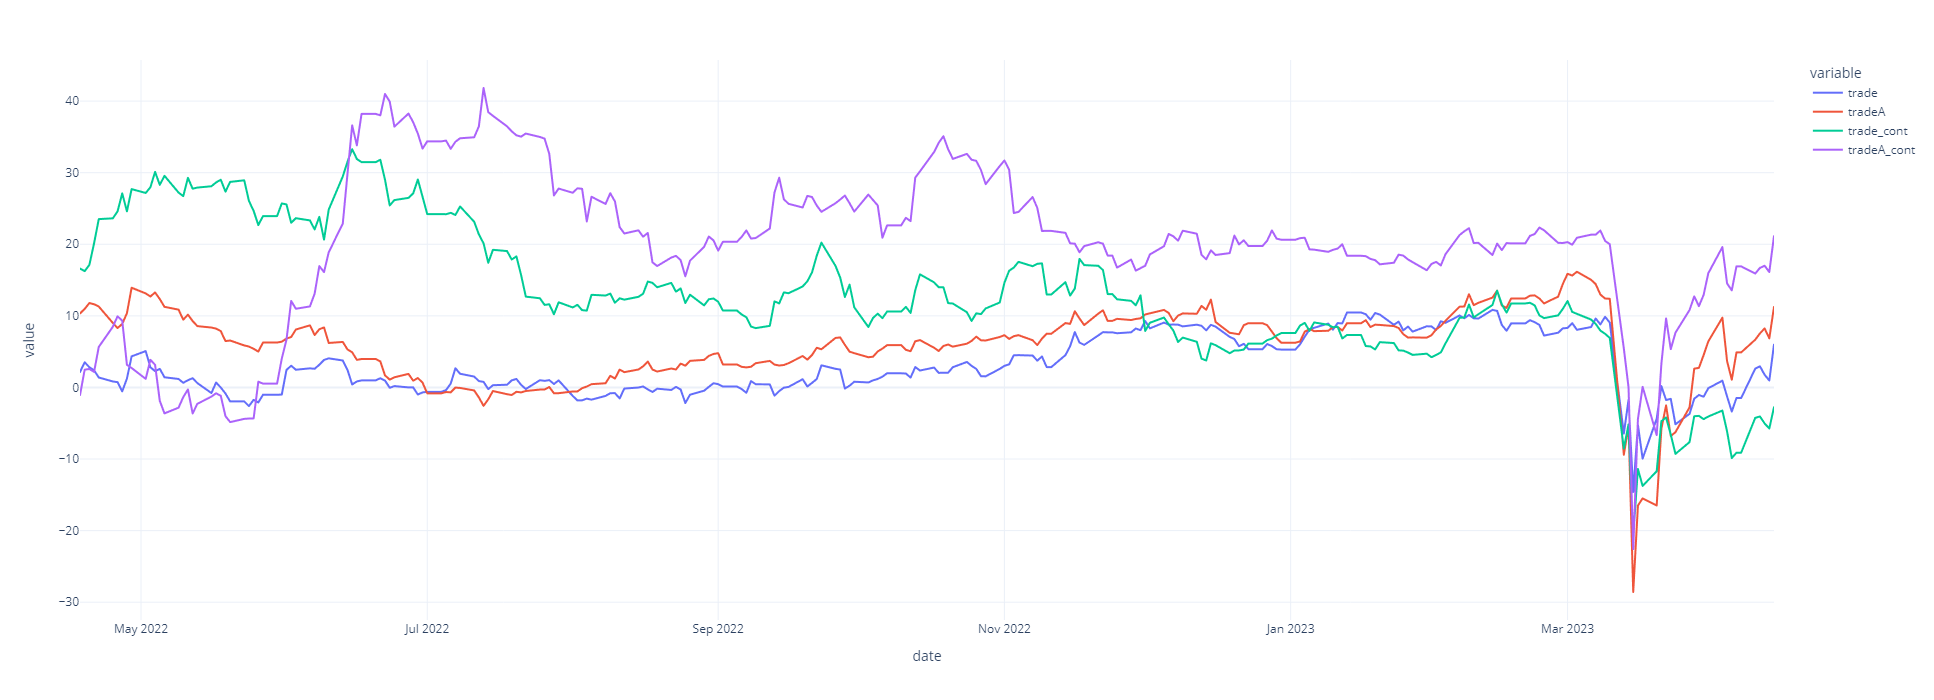

In [56]:
(eh.expressions_data * 1e4).plot(height=700, template='plotly_white')

### EMAIL

In [ ]:
yrs = ['5y', '2y', '1y']

In [ ]:
hp_table = df_to_html(d[1].rename('expr').to_frame())

In [ ]:
res = {'ptf': get_tables_and_figures(eh.expressions_data['ptf'], eh.expressions_data['ptfA'], periods=yrs)}
for series, series_aged in zip(
    eh.expressions_data.drop(['ptf', 'ptfA'], axis=1).iloc[:, :eh.expressions_data.drop(['ptf', 'ptfA'], axis=1).shape[1] // 2], 
    eh.expressions_data.drop(['ptf', 'ptfA'], axis=1).iloc[:, eh.expressions_data.drop(['ptf', 'ptfA'], axis=1).shape[1] // 2:],
):
    tables, figs = get_tables_and_figures(eh.expressions_data[series], eh.expressions_data[series_aged], periods=yrs)
    res[series] = tables, figs

In [ ]:
periods = [f"{round((eh.expressions_data.index[-1] - eh.expressions_data.dropna().index[0]).days / 365.25)}y", *yrs]
html_body = f"<h1 style=\"font-family: Calibri;\">History Plotter Expressions</h1>"
html_body = html_body + hp_table 
html_body = html_body  + ('<br>' * 2) + f"<h1 style=\"font-family: Calibri;\">Charts (when line goes down you make money, y-scale 1mm)</h1>" 
for name, (tables, figs) in res.items():
    for table, fig, period in zip(tables, figs, periods):
        title = f"<h2 style=\"font-family: Calibri;\">{name.upper()} {period.upper()}</h2>"
        html_df = df_to_html(table.style.format(precision=2))
        img_tag = encode_plotly_fig_as_image_tag(fig)
        html_body = html_body + title + html_df + img_tag

In [ ]:
to_email = to_email_all

In [ ]:
message = MIMEMultipart("alternative")
message["Subject"] = f'PTF HISTORY in DELTA terms as of: {pd.Timestamp.now(): %d%b%y %H:%M}'
message["From"] = from_email
message["To"] = ','.join(to_email)

In [ ]:
html_ = MIMEText(html_body, "html")
message.attach(html_)
smtp = smtplib.SMTP(smtp_server)

In [ ]:
smtp.sendmail(from_email, to_email, message.as_string())

In [ ]:
d[0].query('Strategy == "MM:EUR OPEN"')['string'].drop_duplicates().str.replace(r'[\[\]]', '', regex=True).str.lower()

In [ ]:
eh.

In [ ]:
eh.components_data.loc[:, d[0].query('Strategy == "MM:EUR OPEN"')['string'].drop_duplicates().str.replace(r'[\[\]]', '', regex=True).str.lower()].plot()

In [ ]:
eh.components_data.loc[:, d[0].query('Strategy == "MM:EUR OPEN"')['string_aged'].drop_duplicates().str.replace(r'[\[\]]', '', regex=True).str.lower()].plot()